# Importing libraries & Additional functions

## 1. Libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, recall_score, precision_score, classification_report

## 2. GPU

In [2]:
# Version of torch
print(f'torch version: {torch.__version__}')

# Checking whether the GPU is available or not
if torch.cuda.is_available() == True:
  device = 'cuda:0'
  print('GPU available')
else:
  device = 'cpu'
  print('GPU not available')

torch version: 2.1.0+cu118
GPU available


## 3. Data Loading

In [3]:
def data_load(data_set_name, batch_size, shuffle):
  return DataLoader(data_set_name, batch_size=batch_size, pin_memory=True, shuffle=shuffle, drop_last=True)

## 4. Initialization

In [4]:
# Model
def init_model(_net):
  global net, loss_fn, optim
  net = _net.to(device)
  loss_fn = nn.CrossEntropyLoss()
  optim = torch.optim.Adam(net.parameters(), lr=0.0001)

# Epoch
def init_epoch():
  global epoch_cnt
  epoch_cnt = 0

# Logging
def init_log():
  # Initialize all the logs
  global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
  iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
  time_log, log_stack = [], []

## 5. Training

In [5]:
import numpy as np
def epoch(data_loader):
  global epoch_cnt
  iter_loss, iter_acc = [], []
  last_grad_performed = False

  for _data, _label in data_loader:
    data, label = _data.to(device), _label.to(device)

    # 1. Feed-forward
    result = net(data)
    _, out = torch.max(result, 1)

    # 2. Calculate loss
    loss = loss_fn(result, label)
    iter_loss.append(loss.item())

    # 3. Backward propagation(ony for train mode)
    if result.requires_grad:
      optim.zero_grad()
      loss.backward()
      optim.step()
      last_grad_performed = True

    acc_partial = (out == label).float().sum()
    acc_partial = acc_partial / len(label)
    iter_acc.append(acc_partial.item())

  if last_grad_performed:
    epoch_cnt += 1

  return np.average(iter_loss), np.average(iter_acc)

def epoch_not_finished():
  return epoch_cnt < maximum_epoch

## 6. Traing history

In [6]:
def record_train_log(_tloss, _tacc, _time):
  # Train Log
  time_log.append(_time)
  tloss_log.append(_tloss)
  tacc_log.append(_tacc)
  iter_log.append(epoch_cnt)

def record_valid_log(_vloss, _vacc):
    # Validation Log
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # return the last value
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1

from IPython.display import clear_output
def print_log():
    # decimal point 3
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)

    log_str = 'Epoch: {:3} | T_Loss {:5} | T_acc {:5} | V_Loss {:5} | V_acc. {:5} | 🕒 {:5}'.format(last(iter_log), train_loss, train_acc, val_loss, val_acc, time_spent)

    log_stack.append(log_str)

    # Pring the Learing trend
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99) # set the graph size
    hist_fig.patch.set_facecolor('white') # set the color of background

    # Loss Line
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')

    # Acc. Line
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')

    # Print graph
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line # integrate plts above
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines], loc = 'upper right') # draw in order
    loss_axis.grid() # set grid
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()

    # print text log
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))): # sort reverse and print
        print(log_stack[idx])

## 7. Confusion matrix

In [7]:
def confusion(y_pred, y_true):# constant for classes

  cm1 = confusion_matrix(y_pred, y_true, normalize = "true")
  f1 = f1_score(y_pred, y_true)
  sns.heatmap(cm1, annot = True, cmap="Blues", cbar = False)
  plt.text(0.63, 2.6, f"f1-Score: {f1:.3f}")
  plt.subplots_adjust(bottom=0.1, right=1.2, top=1)
  plt.savefig('confusion.png')
  plt.show()

## 8. ROC curve

In [8]:
def roc(y_pred, y_ture):
  print("Confusion matrix : \n{}".format(confusion_matrix(y_true, y_pred)), "\n")
  print(classification_report(y_true, y_pred, digits=3))

  fpr, tpr, thresholds=roc_curve(y_true, y_pred)
  roc_auc=auc(fpr, tpr)

  plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
  plt.legend(loc='lower right')
  plt.ylabel('TPR'); plt.xlabel('FPR')
  plt.savefig('roc.png')
  plt.show()

# Loading the dataset

In [9]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [10]:
# Hyperparameter
batch_size = 32
maximum_epoch = 15

## Original

In [15]:
trans_original = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()])

train_set_40x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_40x/train', transform = trans_original)
val_set_40x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_40x/eval', transform = trans_original)
train_set_200x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_200x/train', transform = trans_original)
val_set_200x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_200x/eval', transform = trans_original)

# Additional function3: data_loader
train_set_40x_loader = data_load(train_set_40x, batch_size, shuffle=True)
val_set_40x_loader = data_load(val_set_40x, batch_size, shuffle=False)
train_set_200x_loader = data_load(train_set_200x, batch_size, shuffle=True)
val_set_200x_loader = data_load(val_set_200x, batch_size, shuffle=False)

In [36]:
# Data checking
# Train loader is iterable, it is divided by batch. (by HH)
train_enumerator = enumerate(train_set_40x_loader) # Extracting values and indices of train_loader
ex_batch_idx, (ex_data, ex_label) = next(train_enumerator)
print(f'Order: {ex_batch_idx} / X shape: {ex_data.shape} / Y shape: {ex_label.shape}')
print(f'Y 0 ~ {batch_size} print: {ex_label}')

Order: 0 / X shape: torch.Size([32, 3, 460, 700]) / Y shape: torch.Size([32])
Y 0 ~ 32 print: tensor([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 1, 1])


## Zoom

In [78]:
import albumentations as A
import cv2

transform = A.Compose([
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.3, 0.3)),
    transforms.ToTensor()
])

train_set_scaled_40x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_40x/train', transform = trans_zoom)
val_set_scaled_40x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_40x/eval', transform = trans_zoom)
train_set_scaled_200x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_200x/train', transform = trans_zoom)
val_set_scaled_200x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_200x/eval', transform = trans_zoom)

# Additional function3: data_loader
train_set_scaled_40x_loader = data_load(train_set_scaled_40x, batch_size, shuffle=True)
val_set_scaled_40x_loader = data_load(val_set_scaled_40x, batch_size, shuffle=False)
train_set_scaled_200x_loader = data_load(train_set_scaled_200x, batch_size, shuffle=True)
val_set_scaled_200x_loader = data_load(val_set_scaled_200x, batch_size, shuffle=False)

## Brightness

In [ ]:
trans_brightened = transforms.Compose([
    transforms.Resize(224, 224),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor()])

train_set_brightened_40x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_40x/train', transform = trans_brightened)
val_set_brightened_40x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_40x/eval', transform = trans_brightened)
train_set_brightened_200x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_200x/train', transform = trans_brightened)
val_set_brightened_200x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_200x/eval', transform = trans_brightened)

# Additional function3: data_loader
train_set_brightened_40x_loader = data_load(train_set_brightened_40x, batch_size, shuffle=True)
val_set_brightened_40x_loader = data_load(val_set_brightened_40x, batch_size, shuffle=False)
train_set_brightened_200x_loader = data_load(train_set_brightened_200x, batch_size, shuffle=True)
val_set_brightened_200x_loader = data_load(val_set_brightened_200x, batch_size, shuffle=False)

## Rotation

In [ ]:
trans_rotated = transforms.Compose([
    transforms.Resize(224, 224),
    transforms.RandomRotation(degrees=0.2),
    transforms.ToTensor()])

train_set_rotated_40x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_40x/train', transform = trans_rotated)
val_set_rotated_40x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_40x/eval', transform = trans_rotated)
train_set_rotated_200x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_200x/train', transform = trans_rotated)
val_set_rotated_200x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_200x/eval', transform = trans_rotated)

# Additional function3: data_loader
train_set_rotated_40x_loader = data_load(train_set_rotated_40x, batch_size, shuffle=True)
val_set_rotated_40x_loader = data_load(val_set_rotated_40x, batch_size, shuffle=False)
train_set_rotated_200x_loader = data_load(train_set_rotated_200x, batch_size, shuffle=True)
val_set_rotated_200x_loader = data_load(val_set_rotated_200x, batch_size, shuffle=False)

# Defining a Model

In [12]:
# Define the CNN LSTM model
class CNNLSTMModel(nn.Module):
    def __init__(self):
        super(CNNLSTMModel, self).__init__()
        # Define the CNN layers
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        # Define the fully connected layer
        self.fc = nn.Linear(64, 2)  # Output size is 2 for binary classification

    def forward(self, x):
        # Forward pass through CNN layers
        x = self.cnn(x)
        # Reshape for LSTM
        x = x.view(x.size(0), -1, 128)  # Flatten the spatial dimensions
        # Forward pass through LSTM
        lstm_out, _ = self.lstm(x)
        # Take the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        # Forward pass through fully connected layer
        out = self.fc(lstm_out)
        return out

In [56]:
# Model structure check
!pip install torchinfo
from torchvision import models
from torchinfo import summary
summary(CNNLSTMModel().to(device), (32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTMModel                             [32, 2]                   --
├─Sequential: 1-1                        [32, 128, 56, 56]         --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-3                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-4                       [32, 128, 112, 112]       73,856
│    └─ReLU: 2-5                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-6                    [32, 128, 56, 56]         --
├─LSTM: 1-2                              [32, 3136, 64]            49,664
├─Linear: 1-3                            [32, 2]                   130
Total params: 125,442
Trainable params: 125,442
Non-trainable params: 0
Total mult-adds (G): 37.51
Input size (MB): 19.27
Forward/backward pass size (MB): 1284.51
Params size (MB): 0.50
Estimated Total Size (MB): 

# Training & Testing

## Loading the test dataset

In [12]:
test_set_200x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_200x/test', transform = trans_original)
test_set_40x = datasets.ImageFolder(root='/content/gdrive/MyDrive/colab_notebooks/ws23_profile_areas/project02/images_40x/test', transform = trans_original)

test_set_200x_loader = DataLoader(test_set_200x)
test_set_40x_loader = DataLoader(test_set_40x)

## Original

#### 200x data

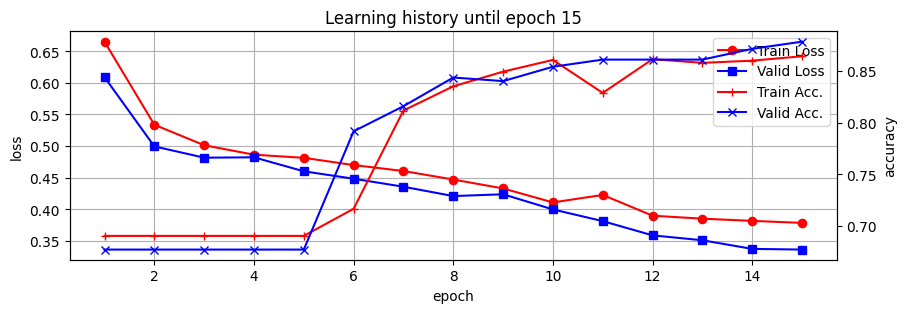

Epoch:  15 | T_Loss 0.379 | T_acc 0.864 | V_Loss 0.336 | V_acc. 0.878 | \🕒 31.721
Epoch:  14 | T_Loss 0.382 | T_acc  0.86 | V_Loss 0.338 | V_acc. 0.872 | \🕒 31.503
Epoch:  13 | T_Loss 0.385 | T_acc 0.858 | V_Loss 0.351 | V_acc. 0.861 | \🕒  31.9
Epoch:  12 | T_Loss  0.39 | T_acc 0.862 | V_Loss 0.359 | V_acc. 0.861 | \🕒 31.275
Epoch:  11 | T_Loss 0.423 | T_acc 0.829 | V_Loss 0.381 | V_acc. 0.861 | \🕒 31.416
Epoch:  10 | T_Loss 0.411 | T_acc 0.861 | V_Loss   0.4 | V_acc. 0.854 | \🕒 31.474
Epoch:   9 | T_Loss 0.433 | T_acc 0.849 | V_Loss 0.424 | V_acc.  0.84 | \🕒 30.753
Epoch:   8 | T_Loss 0.447 | T_acc 0.835 | V_Loss 0.421 | V_acc. 0.844 | \🕒 31.521
Epoch:   7 | T_Loss 0.461 | T_acc 0.812 | V_Loss 0.436 | V_acc. 0.816 | \🕒 31.439
Epoch:   6 | T_Loss  0.47 | T_acc 0.717 | V_Loss 0.448 | V_acc. 0.792 | \🕒 32.458
Epoch:   5 | T_Loss 0.481 | T_acc  0.69 | V_Loss  0.46 | V_acc. 0.677 | \🕒 31.056
Epoch:   4 | T_Loss 0.486 | T_acc  0.69 | V_Loss 0.482 | V_acc. 0.677 | \🕒 31.323
Epoch:   3 | T_Lo

In [ ]:
init_model(CNNLSTMModel())
init_epoch()
init_log()

losses_train, losses_val = [], []

# Training iteration
import time
while epoch_not_finished():
  start_time = time.time() # timer start
  tloss, tacc = epoch(train_set_200x_loader)
  losses_train.append(tloss)
  end_time = time.time() # timer end
  time_taken = end_time - start_time
  record_train_log(tloss, tacc, time_taken)
  with torch.no_grad(): # do not backpropagate
    vloss, vacc = epoch(val_set_200x_loader)
    losses_val.append(vloss)
    record_valid_log(vloss, vacc)
  print_log()

print('\n Training completed !')

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

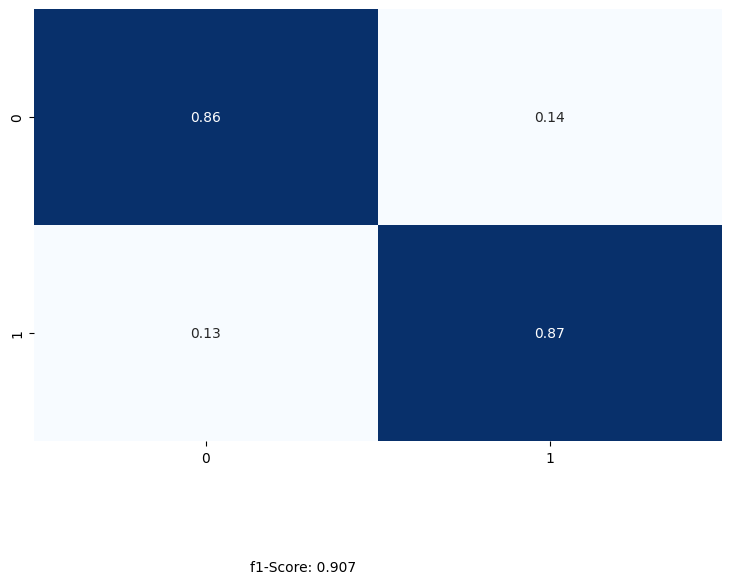

Confusion matrix : 
[[ 63  31]
 [ 10 200]] 

              precision    recall  f1-score   support

           0      0.863     0.670     0.754        94
           1      0.866     0.952     0.907       210

    accuracy                          0.865       304
   macro avg      0.864     0.811     0.831       304
weighted avg      0.865     0.865     0.860       304



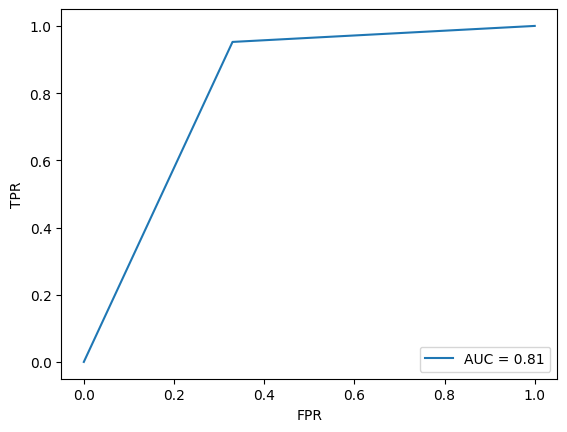

In [ ]:
confusion(y_pred, y_true)
roc(y_pred, y_true)

In [ ]:
with torch.no_grad(): # turn off autograd (by HH)
  test_loss, test_acc = epoch(test_loader)
  test_acc = round(test_acc, 4)
  test_loss = round(test_loss, 4)
  print(f'Test Acc.: {test_acc}')
  print(f'Test Loss: {test_loss}')

Test Acc.: 0.8651
Test Loss: 0.3583


#### 40x data

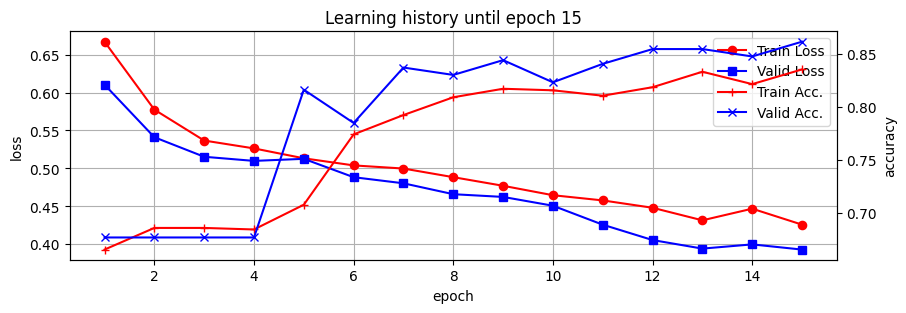

Epoch:  15 | T_Loss 0.426 | T_acc 0.835 | V_Loss 0.393 | V_acc. 0.861 | \🕒 30.16
Epoch:  14 | T_Loss 0.447 | T_acc 0.821 | V_Loss   0.4 | V_acc. 0.847 | \🕒 30.323
Epoch:  13 | T_Loss 0.431 | T_acc 0.833 | V_Loss 0.394 | V_acc. 0.854 | \🕒 30.709
Epoch:  12 | T_Loss 0.448 | T_acc 0.818 | V_Loss 0.405 | V_acc. 0.854 | \🕒 30.576
Epoch:  11 | T_Loss 0.458 | T_acc  0.81 | V_Loss 0.426 | V_acc.  0.84 | \🕒 31.276
Epoch:  10 | T_Loss 0.464 | T_acc 0.815 | V_Loss 0.451 | V_acc. 0.823 | \🕒 29.691
Epoch:   9 | T_Loss 0.477 | T_acc 0.817 | V_Loss 0.462 | V_acc. 0.844 | \🕒 30.713
Epoch:   8 | T_Loss 0.488 | T_acc 0.809 | V_Loss 0.466 | V_acc.  0.83 | \🕒 30.571
Epoch:   7 | T_Loss   0.5 | T_acc 0.792 | V_Loss  0.48 | V_acc. 0.837 | \🕒 30.986
Epoch:   6 | T_Loss 0.504 | T_acc 0.774 | V_Loss 0.488 | V_acc. 0.785 | \🕒 30.075
Epoch:   5 | T_Loss 0.513 | T_acc 0.708 | V_Loss 0.513 | V_acc. 0.816 | \🕒 30.121
Epoch:   4 | T_Loss 0.526 | T_acc 0.685 | V_Loss  0.51 | V_acc. 0.677 | \🕒 30.366
Epoch:   3 | T_Lo

In [ ]:
init_model(CNNLSTMModel())
init_epoch()
init_log()

losses_train, losses_val = [], []

# Training iteration
import time
while epoch_not_finished():
  start_time = time.time() # timer start
  tloss, tacc = epoch(train_set_40x_loader)
  losses_train.append(tloss)
  end_time = time.time() # timer end
  time_taken = end_time - start_time
  record_train_log(tloss, tacc, time_taken)
  with torch.no_grad(): # do not backpropagate
    vloss, vacc = epoch(val_set_40x_loader)
    losses_val.append(vloss)
    record_valid_log(vloss, vacc)
  print_log()

print('\n Training completed !')

In [ ]:
y_pred_40 = []
y_true_40 = []

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_40.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true_40.extend(labels) # Save Truth


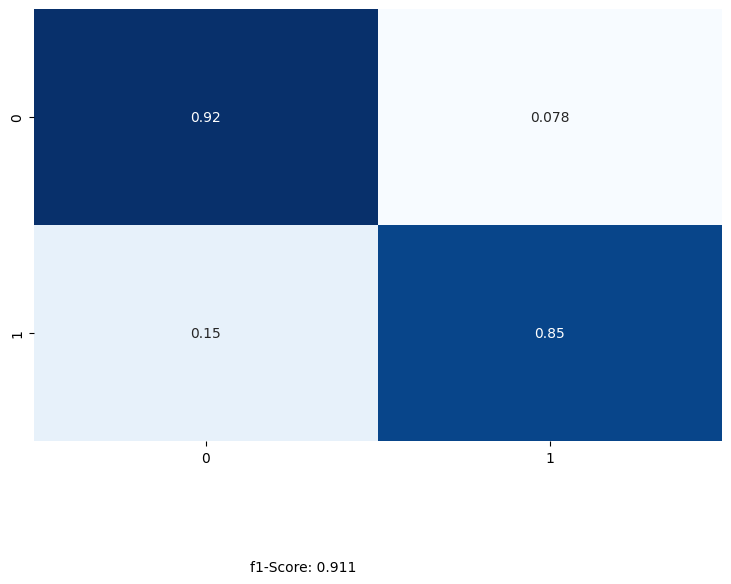

Confusion matrix : 
[[ 59  35]
 [  5 205]] 

              precision    recall  f1-score   support

           0      0.922     0.628     0.747        94
           1      0.854     0.976     0.911       210

    accuracy                          0.868       304
   macro avg      0.888     0.802     0.829       304
weighted avg      0.875     0.868     0.860       304



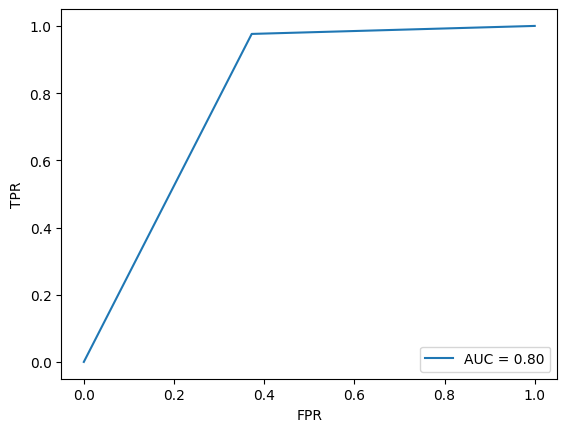

In [ ]:
confusion(y_pred_40, y_true_40)
roc(y_pred_40, y_true_40)

#### ROC curve (200x, 40x)

Confusion matrix 200x : 
[[ 63  31]
 [ 10 200]] 

              precision    recall  f1-score   support

           0      0.863     0.670     0.754        94
           1      0.866     0.952     0.907       210

    accuracy                          0.865       304
   macro avg      0.864     0.811     0.831       304
weighted avg      0.865     0.865     0.860       304

Confusion matrix 40x: 
[[ 59  35]
 [  5 205]] 

              precision    recall  f1-score   support

           0      0.922     0.628     0.747        94
           1      0.854     0.976     0.911       210

    accuracy                          0.868       304
   macro avg      0.888     0.802     0.829       304
weighted avg      0.875     0.868     0.860       304



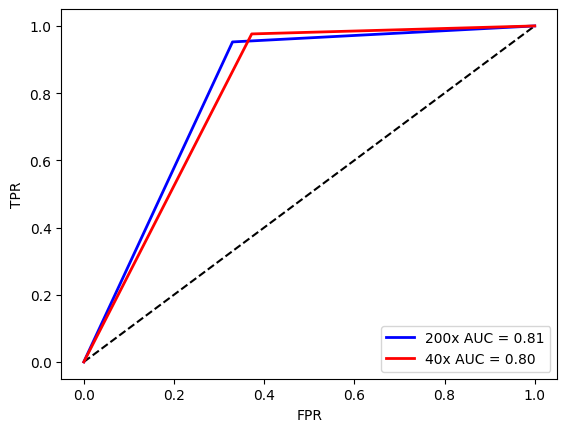

In [ ]:
# roc(y_pred_40, y_true_40)
print("Confusion matrix 200x : \n{}".format(confusion_matrix(y_true, y_pred)), "\n")
print(classification_report(y_true, y_pred, digits=3))

print("Confusion matrix 40x: \n{}".format(confusion_matrix(y_true_40, y_pred_40)), "\n")
print(classification_report(y_true_40, y_pred_40, digits=3))

fpr1, tpr1, thresholds=roc_curve(y_true, y_pred)
roc_auc1=auc(fpr1, tpr1)
fpr2, tpr2, thresholds=roc_curve(y_true_40, y_pred_40)
roc_auc2=auc(fpr2, tpr2)

# plt.plot(fpr1, tpr1, label='AUC = %0.2f' % roc_auc)
# plt.plot(fpr2, tpr2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, color='blue', lw=2, label='200x AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', lw=2, label='40x AUC = %0.2f' % roc_auc2)
plt.legend(['200x','40x'])
plt.legend(loc='lower right')
plt.ylabel('TPR'); plt.xlabel('FPR')
plt.show()

## Zoom

#### 200x data

In [ ]:
init_model(CNNLSTMModel())
init_epoch()
init_log()

losses_train, losses_val = [], []

# Training iteration
import time
while epoch_not_finished():
  start_time = time.time() # timer start
  tloss, tacc = epoch(train_set_scaled_200x_loader)
  losses_train.append(tloss)
  end_time = time.time() # timer end
  time_taken = end_time - start_time
  record_train_log(tloss, tacc, time_taken)
  with torch.no_grad(): # do not backpropagate
    vloss, vacc = epoch(val_set_scaled_200x_loader)
    losses_val.append(vloss)
    record_valid_log(vloss, vacc)
  print_log()

print('\n Training completed !')

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [ ]:
confustion_matrix(y_pred, y_true)
roc(y_pred, y_true)

#### 40x data

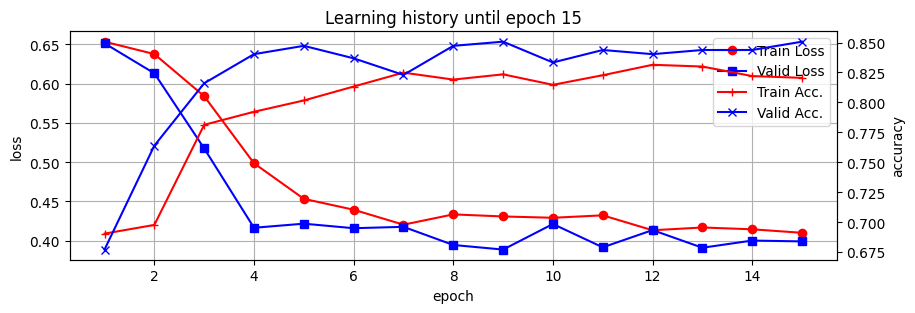

Epoch:  15 | T_Loss  0.41 | T_acc  0.82 | V_Loss 0.399 | V_acc. 0.851 | \🕒 31.278
Epoch:  14 | T_Loss 0.415 | T_acc 0.822 | V_Loss   0.4 | V_acc. 0.844 | \🕒 30.905
Epoch:  13 | T_Loss 0.417 | T_acc  0.83 | V_Loss 0.391 | V_acc. 0.844 | \🕒 29.992
Epoch:  12 | T_Loss 0.413 | T_acc 0.831 | V_Loss 0.414 | V_acc.  0.84 | \🕒 30.454
Epoch:  11 | T_Loss 0.432 | T_acc 0.823 | V_Loss 0.392 | V_acc. 0.844 | \🕒 31.156
Epoch:  10 | T_Loss 0.429 | T_acc 0.815 | V_Loss 0.421 | V_acc. 0.833 | \🕒 30.699
Epoch:   9 | T_Loss 0.431 | T_acc 0.823 | V_Loss 0.389 | V_acc. 0.851 | \🕒 30.908
Epoch:   8 | T_Loss 0.434 | T_acc 0.819 | V_Loss 0.395 | V_acc. 0.847 | \🕒 31.422
Epoch:   7 | T_Loss 0.421 | T_acc 0.825 | V_Loss 0.418 | V_acc. 0.823 | \🕒 30.979
Epoch:   6 | T_Loss  0.44 | T_acc 0.813 | V_Loss 0.416 | V_acc. 0.837 | \🕒 31.298
Epoch:   5 | T_Loss 0.453 | T_acc 0.802 | V_Loss 0.422 | V_acc. 0.847 | \🕒 35.785
Epoch:   4 | T_Loss 0.499 | T_acc 0.792 | V_Loss 0.417 | V_acc.  0.84 | \🕒 30.277
Epoch:   3 | T_L

In [ ]:
init_model(CNNLSTMModel())
init_epoch()
init_log()

losses_train, losses_val = [], []

# Training iteration
import time
while epoch_not_finished():
  start_time = time.time() # timer start
  tloss, tacc = epoch(train_set_scaled_40x_loader)
  losses_train.append(tloss)
  end_time = time.time() # timer end
  time_taken = end_time - start_time
  record_train_log(tloss, tacc, time_taken)
  with torch.no_grad(): # do not backpropagate
    vloss, vacc = epoch(val_set_scaled_40x_loader)
    losses_val.append(vloss)
    record_valid_log(vloss, vacc)
  print_log()

print('\n Training completed !')

In [ ]:
y_pred_40 = []
y_true_40 = []

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_40.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true_40.extend(labels) # Save Truth


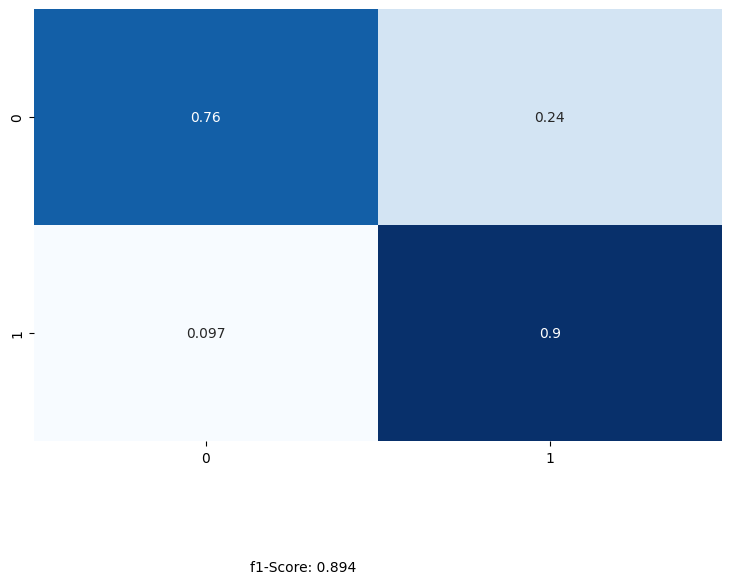

Confusion matrix : 
[[ 74  20]
 [ 24 186]] 

              precision    recall  f1-score   support

           0      0.755     0.787     0.771        94
           1      0.903     0.886     0.894       210

    accuracy                          0.855       304
   macro avg      0.829     0.836     0.833       304
weighted avg      0.857     0.855     0.856       304



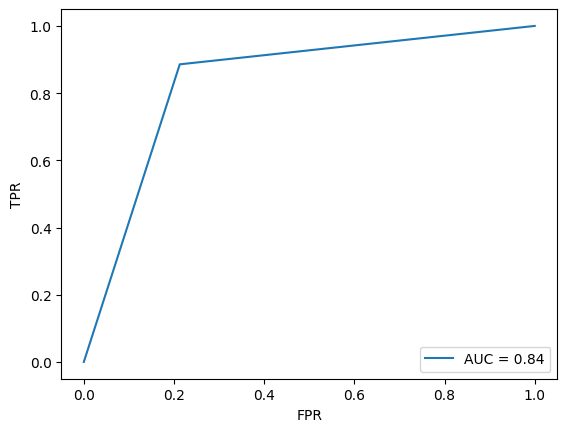

In [ ]:
confusion(y_pred_40, y_true_40)
roc(y_pred_40, y_true_40)

#### ROC curve (200x, 40x)

Confusion matrix 200x : 
[[ 59  35]
 [ 10 200]] 

              precision    recall  f1-score   support

           0      0.855     0.628     0.724        94
           1      0.851     0.952     0.899       210

    accuracy                          0.852       304
   macro avg      0.853     0.790     0.811       304
weighted avg      0.852     0.852     0.845       304

Confusion matrix 40x: 
[[ 74  20]
 [ 24 186]] 

              precision    recall  f1-score   support

           0      0.755     0.787     0.771        94
           1      0.903     0.886     0.894       210

    accuracy                          0.855       304
   macro avg      0.829     0.836     0.833       304
weighted avg      0.857     0.855     0.856       304



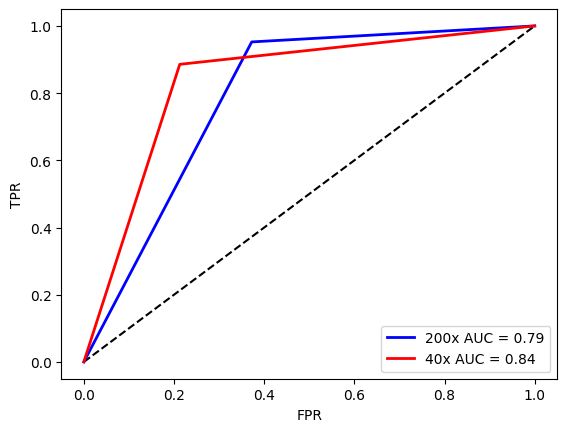

In [ ]:
# roc(y_pred_40, y_true_40)
print("Confusion matrix 200x : \n{}".format(confusion_matrix(y_true, y_pred)), "\n")
print(classification_report(y_true, y_pred, digits=3))

print("Confusion matrix 40x: \n{}".format(confusion_matrix(y_true_40, y_pred_40)), "\n")
print(classification_report(y_true_40, y_pred_40, digits=3))

fpr1, tpr1, thresholds=roc_curve(y_true, y_pred)
roc_auc1=auc(fpr1, tpr1)
fpr2, tpr2, thresholds=roc_curve(y_true_40, y_pred_40)
roc_auc2=auc(fpr2, tpr2)

# plt.plot(fpr1, tpr1, label='AUC = %0.2f' % roc_auc)
# plt.plot(fpr2, tpr2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, color='blue', lw=2, label='200x AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', lw=2, label='40x AUC = %0.2f' % roc_auc2)
plt.legend(['200x','40x'])
plt.legend(loc='lower right')
plt.ylabel('TPR'); plt.xlabel('FPR')
plt.show()

## Brightness

#### 200x data

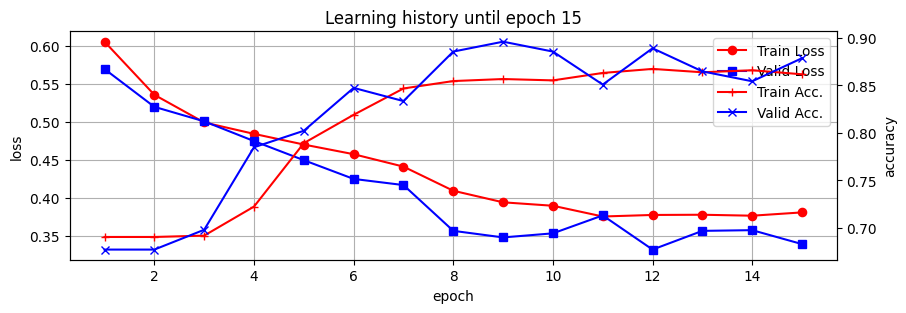

Epoch:  15 | T_Loss 0.381 | T_acc 0.862 | V_Loss 0.339 | V_acc. 0.878 | \🕒 32.911
Epoch:  14 | T_Loss 0.376 | T_acc 0.866 | V_Loss 0.357 | V_acc. 0.854 | \🕒 32.692
Epoch:  13 | T_Loss 0.378 | T_acc 0.864 | V_Loss 0.356 | V_acc. 0.865 | \🕒 33.273
Epoch:  12 | T_Loss 0.377 | T_acc 0.867 | V_Loss 0.332 | V_acc. 0.889 | \🕒 32.203
Epoch:  11 | T_Loss 0.375 | T_acc 0.863 | V_Loss 0.377 | V_acc. 0.851 | \🕒 33.036
Epoch:  10 | T_Loss 0.389 | T_acc 0.855 | V_Loss 0.353 | V_acc. 0.885 | \🕒 32.635
Epoch:   9 | T_Loss 0.394 | T_acc 0.857 | V_Loss 0.348 | V_acc. 0.896 | \🕒 32.398
Epoch:   8 | T_Loss 0.409 | T_acc 0.854 | V_Loss 0.356 | V_acc. 0.885 | \🕒 33.164
Epoch:   7 | T_Loss 0.441 | T_acc 0.847 | V_Loss 0.417 | V_acc. 0.833 | \🕒 33.562
Epoch:   6 | T_Loss 0.457 | T_acc 0.819 | V_Loss 0.425 | V_acc. 0.847 | \🕒 33.392
Epoch:   5 | T_Loss  0.47 | T_acc 0.789 | V_Loss 0.449 | V_acc. 0.802 | \🕒  46.6
Epoch:   4 | T_Loss 0.484 | T_acc 0.722 | V_Loss 0.475 | V_acc. 0.785 | \🕒 32.831
Epoch:   3 | T_Lo

In [ ]:
init_model(CNNLSTMModel())
init_epoch()
init_log()

losses_train, losses_val = [], []

# Training iteration
import time
while epoch_not_finished():
  start_time = time.time() # timer start
  tloss, tacc = epoch(train_set_brightened_200x_loader)
  losses_train.append(tloss)
  end_time = time.time() # timer end
  time_taken = end_time - start_time
  record_train_log(tloss, tacc, time_taken)
  with torch.no_grad(): # do not backpropagate
    vloss, vacc = epoch(val_set_brightened_200x_loader)
    losses_val.append(vloss)
    record_valid_log(vloss, vacc)
  print_log()

print('\n Training completed !')

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

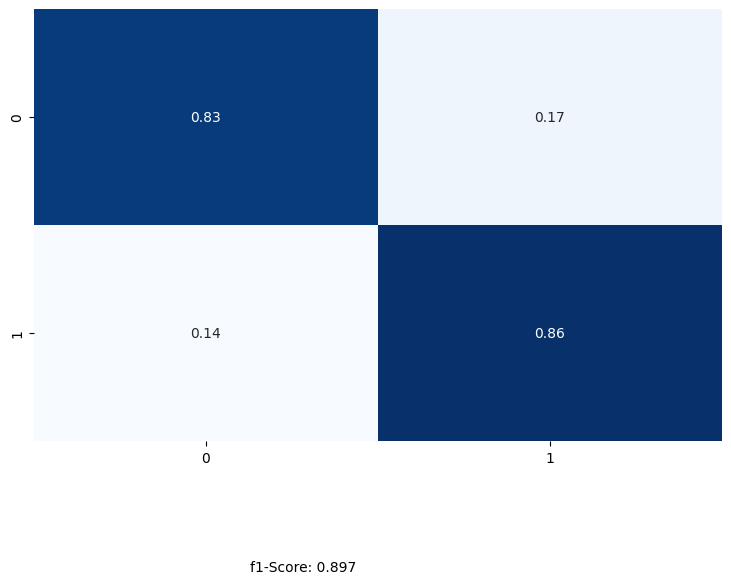

Confusion matrix : 
[[ 62  32]
 [ 13 197]] 

              precision    recall  f1-score   support

           0      0.827     0.660     0.734        94
           1      0.860     0.938     0.897       210

    accuracy                          0.852       304
   macro avg      0.843     0.799     0.816       304
weighted avg      0.850     0.852     0.847       304



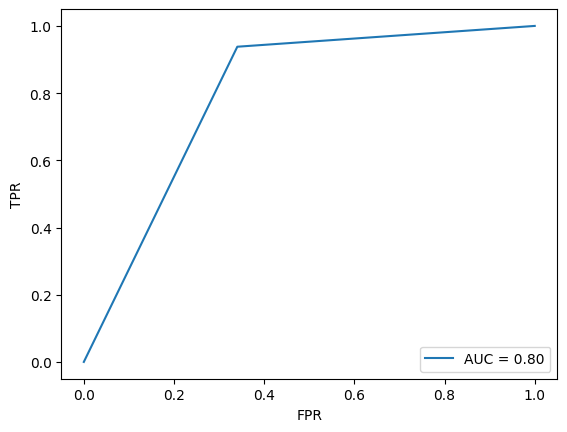

In [ ]:
confusion(y_pred, y_true)
roc(y_pred, y_true)

#### 40x data

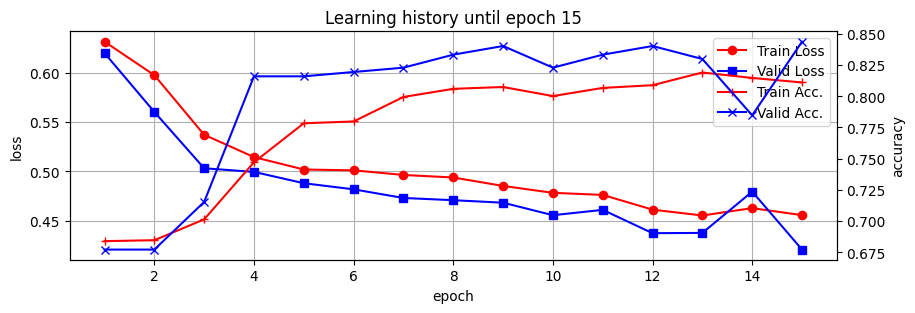

Epoch:  15 | T_Loss 0.456 | T_acc 0.811 | V_Loss 0.421 | V_acc. 0.844 | \🕒 32.499
Epoch:  14 | T_Loss 0.463 | T_acc 0.815 | V_Loss  0.48 | V_acc. 0.785 | \🕒 31.785
Epoch:  13 | T_Loss 0.455 | T_acc 0.819 | V_Loss 0.438 | V_acc.  0.83 | \🕒  32.1
Epoch:  12 | T_Loss 0.461 | T_acc 0.809 | V_Loss 0.437 | V_acc.  0.84 | \🕒 31.431
Epoch:  11 | T_Loss 0.476 | T_acc 0.807 | V_Loss 0.461 | V_acc. 0.833 | \🕒 31.707
Epoch:  10 | T_Loss 0.478 | T_acc   0.8 | V_Loss 0.456 | V_acc. 0.823 | \🕒 31.764
Epoch:   9 | T_Loss 0.485 | T_acc 0.807 | V_Loss 0.468 | V_acc.  0.84 | \🕒 32.83
Epoch:   8 | T_Loss 0.494 | T_acc 0.806 | V_Loss 0.471 | V_acc. 0.833 | \🕒 31.668
Epoch:   7 | T_Loss 0.496 | T_acc 0.799 | V_Loss 0.473 | V_acc. 0.823 | \🕒 31.829
Epoch:   6 | T_Loss 0.501 | T_acc  0.78 | V_Loss 0.482 | V_acc. 0.819 | \🕒 31.706
Epoch:   5 | T_Loss 0.502 | T_acc 0.778 | V_Loss 0.488 | V_acc. 0.816 | \🕒 31.894
Epoch:   4 | T_Loss 0.515 | T_acc 0.747 | V_Loss   0.5 | V_acc. 0.816 | \🕒 31.643
Epoch:   3 | T_Los

In [ ]:
init_model(CNNLSTMModel())
init_epoch()
init_log()

losses_train, losses_val = [], []

# Training iteration
import time
while epoch_not_finished():
  start_time = time.time() # timer start
  tloss, tacc = epoch(train_set_brightened_40x_loader)
  losses_train.append(tloss)
  end_time = time.time() # timer end
  time_taken = end_time - start_time
  record_train_log(tloss, tacc, time_taken)
  with torch.no_grad(): # do not backpropagate
    vloss, vacc = epoch(val_set_brightened_40x_loader)
    losses_val.append(vloss)
    record_valid_log(vloss, vacc)
  print_log()

print('\n Training completed !')

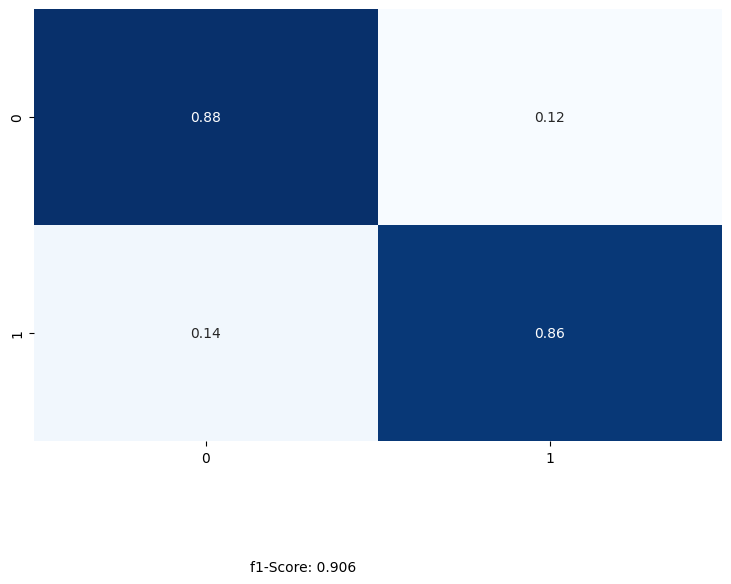

Confusion matrix : 
[[ 60  34]
 [  8 202]] 

              precision    recall  f1-score   support

           0      0.882     0.638     0.741        94
           1      0.856     0.962     0.906       210

    accuracy                          0.862       304
   macro avg      0.869     0.800     0.823       304
weighted avg      0.864     0.862     0.855       304



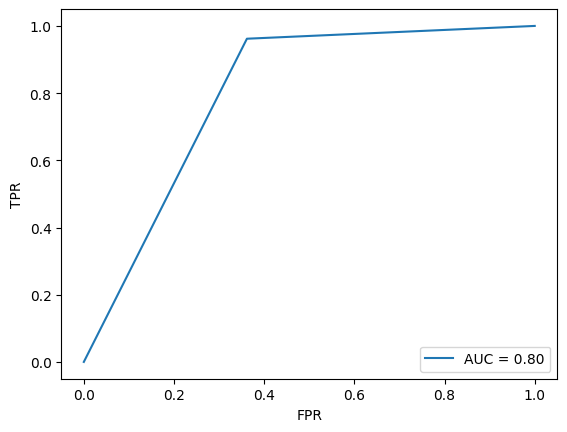

In [ ]:
y_pred_40 = []
y_true_40 = []

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_40.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true_40.extend(labels) # Save Truth

confusion(y_pred_40, y_true_40)
roc(y_pred_40, y_true_40)

#### ROC curve (200x, 40x)

Confusion matrix 200x : 
[[ 62  32]
 [ 13 197]] 

              precision    recall  f1-score   support

           0      0.827     0.660     0.734        94
           1      0.860     0.938     0.897       210

    accuracy                          0.852       304
   macro avg      0.843     0.799     0.816       304
weighted avg      0.850     0.852     0.847       304

Confusion matrix 40x: 
[[ 60  34]
 [  8 202]] 

              precision    recall  f1-score   support

           0      0.882     0.638     0.741        94
           1      0.856     0.962     0.906       210

    accuracy                          0.862       304
   macro avg      0.869     0.800     0.823       304
weighted avg      0.864     0.862     0.855       304



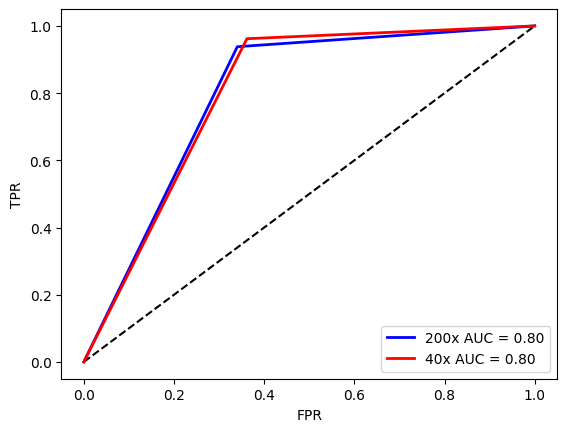

In [ ]:
# roc(y_pred_40, y_true_40)
print("Confusion matrix 200x : \n{}".format(confusion_matrix(y_true, y_pred)), "\n")
print(classification_report(y_true, y_pred, digits=3))

print("Confusion matrix 40x: \n{}".format(confusion_matrix(y_true_40, y_pred_40)), "\n")
print(classification_report(y_true_40, y_pred_40, digits=3))

fpr1, tpr1, thresholds=roc_curve(y_true, y_pred)
roc_auc1=auc(fpr1, tpr1)
fpr2, tpr2, thresholds=roc_curve(y_true_40, y_pred_40)
roc_auc2=auc(fpr2, tpr2)

# plt.plot(fpr1, tpr1, label='AUC = %0.2f' % roc_auc)
# plt.plot(fpr2, tpr2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, color='blue', lw=2, label='200x AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', lw=2, label='40x AUC = %0.2f' % roc_auc2)
plt.legend(['200x','40x'])
plt.legend(loc='lower right')
plt.ylabel('TPR'); plt.xlabel('FPR')
plt.show()

## Rotation

#### 200x data

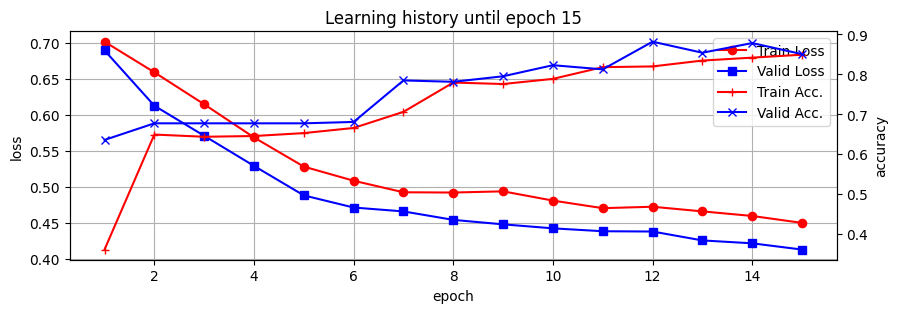

Epoch:  15 | T_Loss  0.45 | T_acc 0.849 | V_Loss 0.413 | V_acc. 0.851 | \🕒 11.227
Epoch:  14 | T_Loss  0.46 | T_acc 0.842 | V_Loss 0.422 | V_acc. 0.878 | \🕒 11.041
Epoch:  13 | T_Loss 0.466 | T_acc 0.835 | V_Loss 0.426 | V_acc. 0.854 | \🕒 11.42
Epoch:  12 | T_Loss 0.472 | T_acc  0.82 | V_Loss 0.438 | V_acc. 0.882 | \🕒 11.931
Epoch:  11 | T_Loss  0.47 | T_acc 0.818 | V_Loss 0.438 | V_acc. 0.812 | \🕒 12.142
Epoch:  10 | T_Loss 0.481 | T_acc 0.789 | V_Loss 0.442 | V_acc. 0.823 | \🕒 12.184
Epoch:   9 | T_Loss 0.494 | T_acc 0.776 | V_Loss 0.448 | V_acc. 0.795 | \🕒 12.004
Epoch:   8 | T_Loss 0.492 | T_acc 0.779 | V_Loss 0.454 | V_acc. 0.781 | \🕒 12.276
Epoch:   7 | T_Loss 0.492 | T_acc 0.706 | V_Loss 0.466 | V_acc. 0.785 | \🕒 11.722
Epoch:   6 | T_Loss 0.508 | T_acc 0.665 | V_Loss 0.471 | V_acc. 0.681 | \🕒 11.037
Epoch:   5 | T_Loss 0.528 | T_acc 0.653 | V_Loss 0.488 | V_acc. 0.677 | \🕒 11.123
Epoch:   4 | T_Loss 0.569 | T_acc 0.645 | V_Loss 0.529 | V_acc. 0.677 | \🕒 16.695
Epoch:   3 | T_Lo

In [ ]:
init_model(CNNLSTMModel())
init_epoch()
init_log()

losses_train, losses_val = [], []

# Training iteration
import time
while epoch_not_finished():
  start_time = time.time() # timer start
  tloss, tacc = epoch(train_set_rotated_200x_loader)
  losses_train.append(tloss)
  end_time = time.time() # timer end
  time_taken = end_time - start_time
  record_train_log(tloss, tacc, time_taken)
  with torch.no_grad(): # do not backpropagate
    vloss, vacc = epoch(val_set_rotated_200x_loader)
    losses_val.append(vloss)
    record_valid_log(vloss, vacc)
  print_log()

print('\n Training completed !')

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

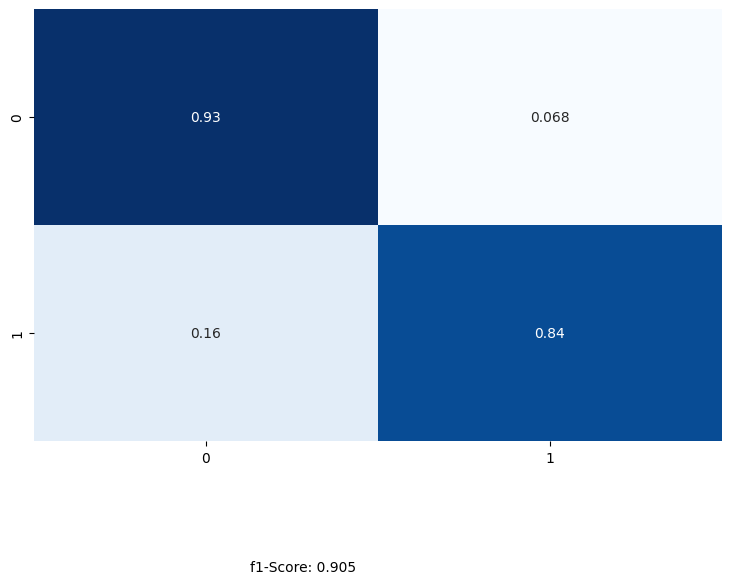

Confusion matrix : 
[[ 55  39]
 [  4 206]] 

              precision    recall  f1-score   support

           0      0.932     0.585     0.719        94
           1      0.841     0.981     0.905       210

    accuracy                          0.859       304
   macro avg      0.887     0.783     0.812       304
weighted avg      0.869     0.859     0.848       304



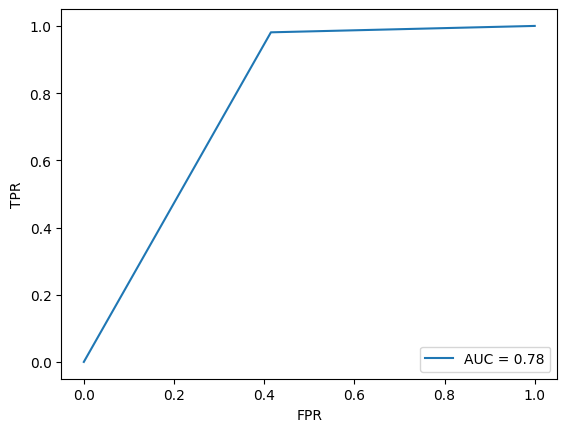

In [ ]:
confusion(y_pred, y_true)
roc(y_pred, y_true)

#### 40x

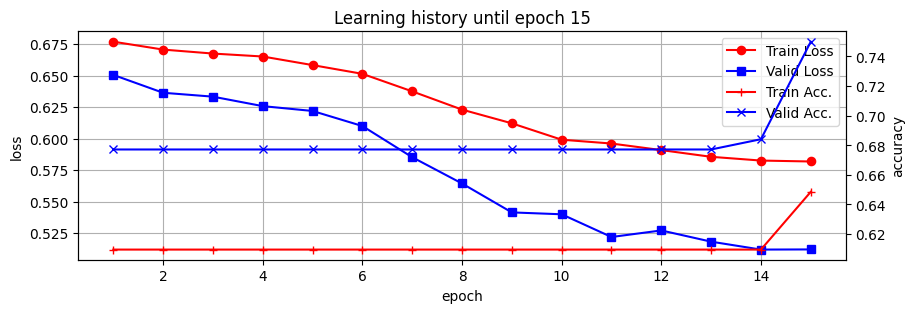

Epoch:  15 | T_Loss 0.582 | T_acc 0.648 | V_Loss 0.512 | V_acc.  0.75 | \🕒 8.055
Epoch:  14 | T_Loss 0.583 | T_acc 0.609 | V_Loss 0.512 | V_acc. 0.684 | \🕒 9.023
Epoch:  13 | T_Loss 0.586 | T_acc 0.609 | V_Loss 0.518 | V_acc. 0.677 | \🕒 8.719
Epoch:  12 | T_Loss 0.591 | T_acc 0.609 | V_Loss 0.527 | V_acc. 0.677 | \🕒 8.987
Epoch:  11 | T_Loss 0.596 | T_acc 0.609 | V_Loss 0.522 | V_acc. 0.677 | \🕒 11.193
Epoch:  10 | T_Loss 0.599 | T_acc 0.609 | V_Loss  0.54 | V_acc. 0.677 | \🕒 9.216
Epoch:   9 | T_Loss 0.612 | T_acc 0.609 | V_Loss 0.541 | V_acc. 0.677 | \🕒  9.15
Epoch:   8 | T_Loss 0.623 | T_acc 0.609 | V_Loss 0.564 | V_acc. 0.677 | \🕒 9.061
Epoch:   7 | T_Loss 0.637 | T_acc 0.609 | V_Loss 0.585 | V_acc. 0.677 | \🕒  9.57
Epoch:   6 | T_Loss 0.651 | T_acc 0.609 | V_Loss  0.61 | V_acc. 0.677 | \🕒 8.632
Epoch:   5 | T_Loss 0.658 | T_acc 0.609 | V_Loss 0.622 | V_acc. 0.677 | \🕒 8.166
Epoch:   4 | T_Loss 0.665 | T_acc 0.609 | V_Loss 0.626 | V_acc. 0.677 | \🕒 10.038
Epoch:   3 | T_Loss 0.667 

In [ ]:
init_model(CNNLSTMModel())
init_epoch()
init_log()

losses_train, losses_val = [], []

# Training iteration
import time
while epoch_not_finished():
  start_time = time.time() # timer start
  tloss, tacc = epoch(train_set_rotated_40x_loader)
  losses_train.append(tloss)
  end_time = time.time() # timer end
  time_taken = end_time - start_time
  record_train_log(tloss, tacc, time_taken)
  with torch.no_grad(): # do not backpropagate
    vloss, vacc = epoch(val_set_rotated_40x_loader)
    losses_val.append(vloss)
    record_valid_log(vloss, vacc)
  print_log()

print('\n Training completed !')

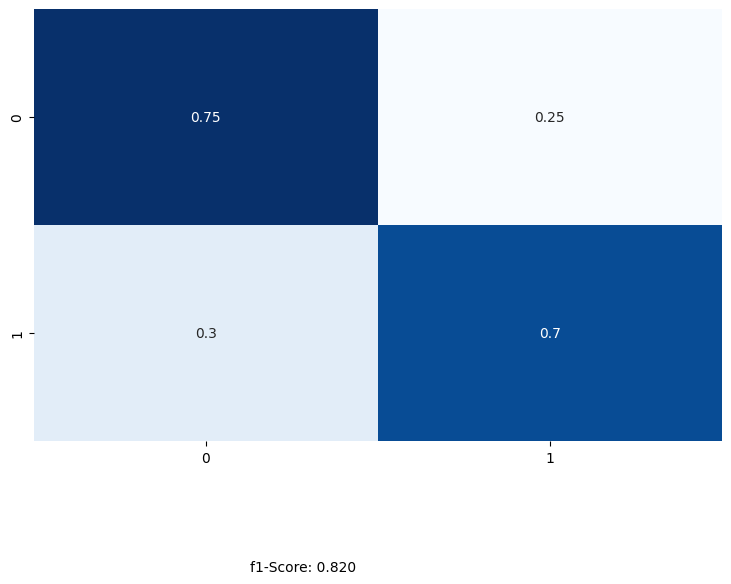

Confusion matrix : 
[[  3  91]
 [  1 209]] 

              precision    recall  f1-score   support

           0      0.750     0.032     0.061        94
           1      0.697     0.995     0.820       210

    accuracy                          0.697       304
   macro avg      0.723     0.514     0.440       304
weighted avg      0.713     0.697     0.585       304



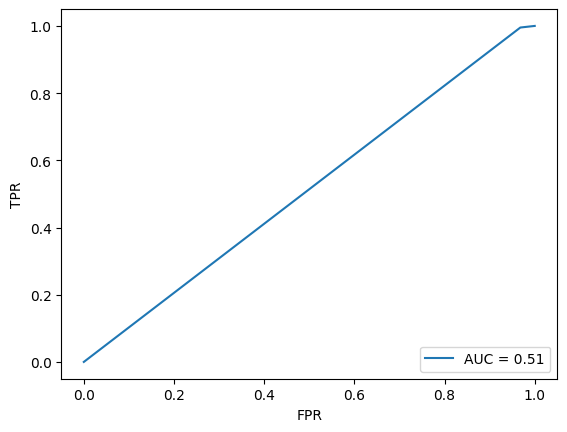

In [ ]:
y_pred_40 = []
y_true_40 = []

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_40.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true_40.extend(labels) # Save Truth

confusion(y_pred_40, y_true_40)
roc(y_pred_40, y_true_40)

#### ROC curve (200x, 40x)

Confusion matrix 200x : 
[[ 55  39]
 [  4 206]] 

              precision    recall  f1-score   support

           0      0.932     0.585     0.719        94
           1      0.841     0.981     0.905       210

    accuracy                          0.859       304
   macro avg      0.887     0.783     0.812       304
weighted avg      0.869     0.859     0.848       304

Confusion matrix 40x: 
[[  3  91]
 [  1 209]] 

              precision    recall  f1-score   support

           0      0.750     0.032     0.061        94
           1      0.697     0.995     0.820       210

    accuracy                          0.697       304
   macro avg      0.723     0.514     0.440       304
weighted avg      0.713     0.697     0.585       304



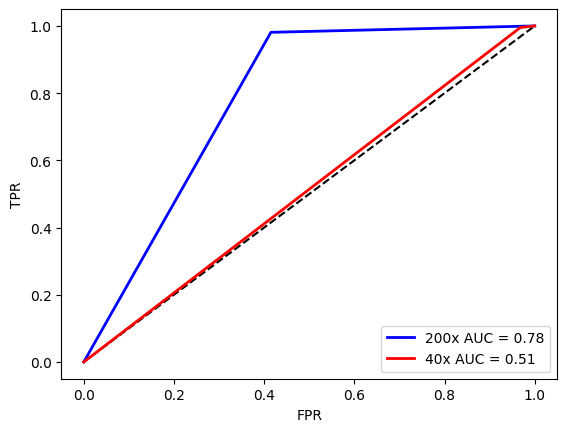

In [ ]:
# roc(y_pred_40, y_true_40)
print("Confusion matrix 200x : \n{}".format(confusion_matrix(y_true, y_pred)), "\n")
print(classification_report(y_true, y_pred, digits=3))

print("Confusion matrix 40x: \n{}".format(confusion_matrix(y_true_40, y_pred_40)), "\n")
print(classification_report(y_true_40, y_pred_40, digits=3))

fpr1, tpr1, thresholds=roc_curve(y_true, y_pred)
roc_auc1=auc(fpr1, tpr1)
fpr2, tpr2, thresholds=roc_curve(y_true_40, y_pred_40)
roc_auc2=auc(fpr2, tpr2)

# plt.plot(fpr1, tpr1, label='AUC = %0.2f' % roc_auc)
# plt.plot(fpr2, tpr2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, color='blue', lw=2, label='200x AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', lw=2, label='40x AUC = %0.2f' % roc_auc2)
plt.legend(['200x','40x'])
plt.legend(loc='lower right')
plt.ylabel('TPR'); plt.xlabel('FPR')
plt.show()